<a href="https://colab.research.google.com/github/eric-pierce/MSDS-422-HW/blob/master/epierce_assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7: Image Processing With a CNN
## MSDS-422 Spring 2019 - Eric Pierce
## Background  
A website provider needs to provide accurate labels to images submitted by end users, and is leveraging a dataset of cat and dog images to identify the best approach to accomplish this.
## Objective
In order to apply these labels, the manager is looking to employ the most accurate modeling approach possible, and prioritizes accuracy over expense. The manager is also looking to understand what types of machine learning models are most effective, and what types of input images are best suited for the model.

# Setup and Data Import
Initialize the data and libraries used as part of this project

### Library Import and Setting Initialization

In [1]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import keras
import itertools
import re, os, cv2, random, json
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from keras import models, layers, optimizers
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

Using TensorFlow backend.


Connect to the Kaggle API so we can source data

In [5]:
!mkdir ~/.kaggle
!mkdir /content/.kaggle

token = {"username":"ericpierce","key":"PUTAPIKEYHERE"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/content/.kaggle’: File exists
- path is now set to: {/content}


### Data Import

In [6]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content
!unzip -q \*.zip

 98% 267M/271M [00:02<00:00, 78.7MB/s]
100% 271M/271M [00:02<00:00, 101MB/s] 
 97% 529M/544M [00:04<00:00, 128MB/s]
100% 544M/544M [00:04<00:00, 130MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 112MB/s]

2 archives were successfully processed.


Remove Cat and Dog pictures that we know are not cats or dogs, or that contain both cats and dogs.

In [0]:
!mkdir bad_images
!mv train/cat.10712.jpg train/cat.11184.jpg train/cat.11222.jpg train/cat.11565.jpg train/cat.1450.jpg train/cat.2159.jpg train/cat.2939.jpg train/cat.3216.jpg train/cat.3822.jpg train/cat.4104.jpg train/cat.4688.jpg train/cat.4833.jpg train/cat.5351.jpg train/cat.5355.jpg train/cat.5418.jpg train/cat.7194.jpg train/cat.7377.jpg train/cat.7564.jpg train/cat.7920.jpg train/cat.7968.jpg train/cat.8456.jpg train/cat.8470.jpg train/cat.9171.jpg train/cat.9444.jpg train/cat.9882.jpg train/dog.10161.jpg train/dog.10190.jpg train/dog.10237.jpg train/dog.1043.jpg train/dog.10747.jpg train/dog.10797.jpg train/dog.11186.jpg train/dog.11538.jpg train/dog.1194.jpg train/dog.12376.jpg train/dog.1308.jpg train/dog.1773.jpg train/dog.1895.jpg train/dog.2614.jpg train/dog.2877.jpg train/dog.4334.jpg train/dog.4367.jpg train/dog.5604.jpg train/dog.8507.jpg train/dog.8736.jpg train/dog.8898.jpg train/dog.9188.jpg train/dog.9517.jpg bad_images

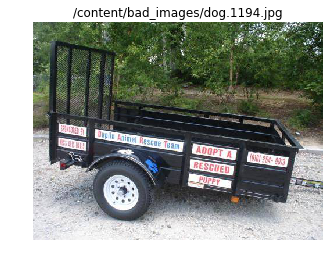

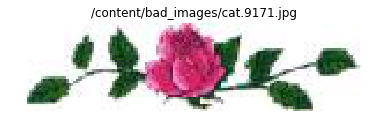

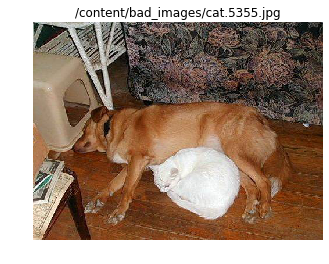

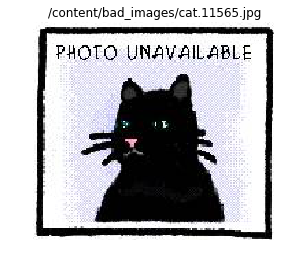

In [8]:
BI_DIR = '/content/bad_images/'
bad_images = [BI_DIR+i for i in os.listdir(BI_DIR)]
random.shuffle(bad_images)
for i in range(0,4):
  plt.imshow(mpimg.imread(bad_images[i]))
  plt.title(bad_images[i])
  plt.axis("off")
  plt.show()

Define Image Processing Functions

In [0]:
def read_image(file_path):
    img = cv2.imread(file_path)[...,::-1]
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

def sample_catdogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.axis("off")
    plt.show()
    
def prepare_data(list_of_images):
    x = []
    y = []
    j=0
    count = len(list_of_images)
    
    for image in list_of_images:
      j=j+1
      img = cv2.imread(image)[...,::-1]
      x.append(cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC))
      if j%500 == 0: print('Processed {} of {}'.format(j, count))

      if 'dog' in image:
          y.append(1)
      elif 'cat' in image:
          y.append(0)

    return np.array(x), np.array(y)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

Image processing, classification (from filename) and scaling.
We're scaling these images

In [10]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

test_images.sort(key=natural_keys)

#train_images = train_dogs[:5000] + train_cats[:5000]
random.shuffle(train_images)
#test_images = test_images[:200]

train, train_labels = prepare_data(train_images)
test, test_labels = prepare_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 500 of 24952
Processed 1000 of 24952
Processed 1500 of 24952
Processed 2000 of 24952
Processed 2500 of 24952
Processed 3000 of 24952
Processed 3500 of 24952
Processed 4000 of 24952
Processed 4500 of 24952
Processed 5000 of 24952
Processed 5500 of 24952
Processed 6000 of 24952
Processed 6500 of 24952
Processed 7000 of 24952
Processed 7500 of 24952
Processed 8000 of 24952
Processed 8500 of 24952
Processed 9000 of 24952
Processed 9500 of 24952
Processed 10000 of 24952
Processed 10500 of 24952
Processed 11000 of 24952
Processed 11500 of 24952
Processed 12000 of 24952
Processed 12500 of 24952
Processed 13000 of 24952
Processed 13500 of 24952
Processed 14000 of 24952
Processed 14500 of 24952
Processed 15000 of 24952
Processed 15500 of 24952
Processed 16000 of 24952
Processed 16500 of 24952
Processed 17000 of 24952
Processed 17500 of 24952
Processed 18000 of 24952
Processed 18500 of 24952
Processed 19000 of 24952
Processed 19500 of 24952
Processed 20000 of 24952
Processed 20500 of 2

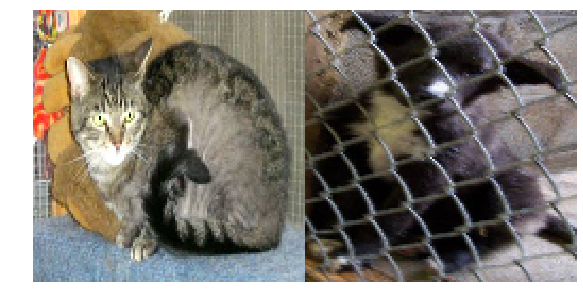

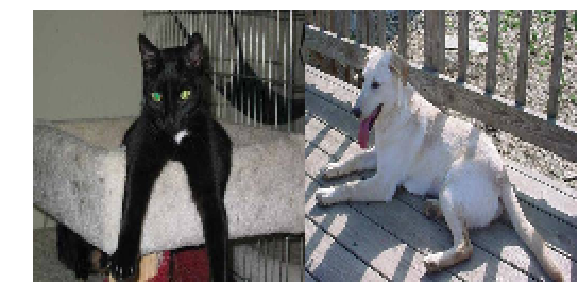

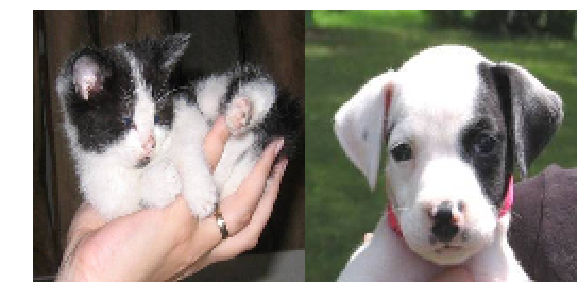

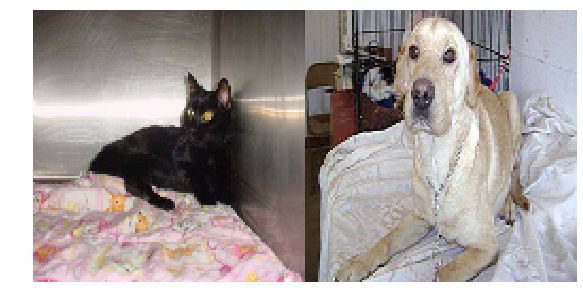

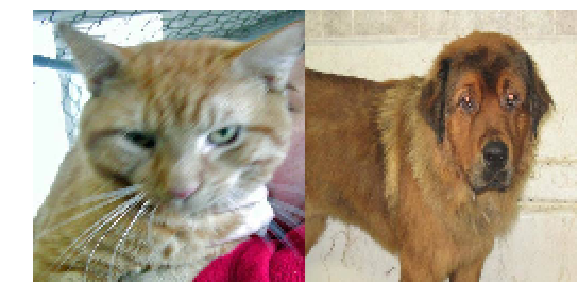

In [0]:
   for image in range(0,5):
    sample_catdogs(image)

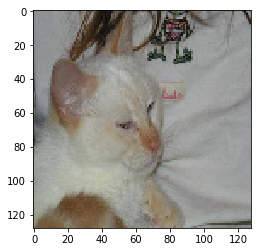

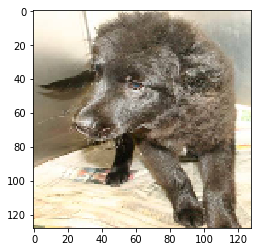

In [0]:
plt.imshow(train[500])
plt.show()
plt.imshow(test[500])
plt.show()

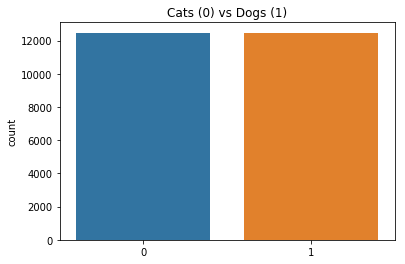

In [0]:
sns.countplot(train_labels)
plt.title("Cats (0) vs Dogs (1)")
plt.show()

# Initial Tensorflow Model Training with Keras

### Model Definition and Training

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, train_labels, random_state=RANDOM_SEED)

np.shape(x_train)

(18714, 128, 128, 3)

1


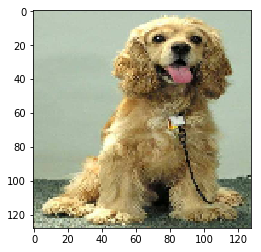

0


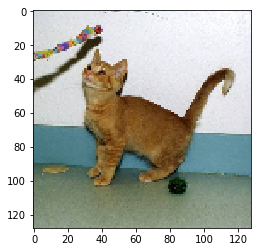

In [0]:
print(y_train[500])
plt.imshow(x_train[500])
plt.show()

print(y_test[800])
plt.imshow(x_test[800])
plt.show()

In [0]:
batch_size = 32
epochs = 10

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics = ['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
__________

Run Model

In [0]:
start=datetime.datetime.now()
history=model.fit(x_train, y_train, batch_size=batch_size, 
                epochs=epochs, verbose=1, 
                validation_data=(x_test, y_test))
end=datetime.datetime.now()

time1=end-start
print("Time required to fit",end-start)
score1=model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Train on 18714 samples, validate on 6238 samples
Epoch 1/10
18714/18714 [==============================] - 15s 779us/step - loss: 8.0553 - acc: 0.4999 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 2/10
18714/18714 [==============================] - 14s 745us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 3/10
18714/18714 [==============================] - 14s 732us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 4/10
18714/18714 [==============================] - 14s 731us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 5/10
18714/18714 [==============================] - 14s 738us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 6/10
18714/18714 [==============================] - 14s 737us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0513 - val_acc: 0.5005
Epoch 7/10
18714/18714 [==============================] - 14s 730us/step - loss: 8.0625 - acc: 0.4998 - val_loss: 8.0

### Model Results and Submission

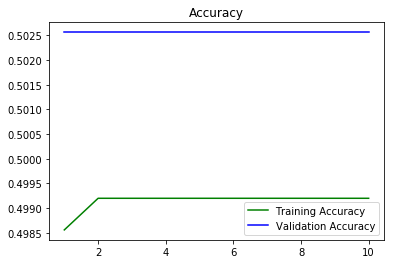

<Figure size 432x288 with 0 Axes>

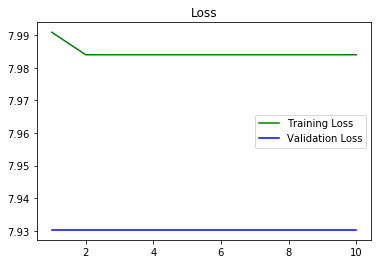

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(1,epochs + 1), history.history['acc'], 'g', label = 'Training Accuracy')
plt.plot(range(1,epochs + 1), history.history['val_acc'], 'b', label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.show()

plt.plot(range(1,epochs + 1), history.history['loss'], 'g', label = 'Training Loss')
plt.plot(range(1,epochs + 1), history.history['val_loss'], 'b', label = 'Validation Loss')
plt.title('Loss')
plt.legend()

plt.figure()
plt.show()

In [0]:
prediction=model.predict(test, verbose=1)

12500/12500 [==============================] - 4s 298us/step


In [0]:
counter = range(1, len(test) + 1)
keras_submission = pd.DataFrame({"id": counter, "label":list(prediction)})
cols = ['label']

for col in cols:
    keras_submission[col] = keras_submission[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_7/catdog_submission_cnn1.csv', index = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


This data was submitted to Kaggle under the username ericpierce and recieved a score of 17.15819

In [0]:
results_df = pd.DataFrame({'TestName': 'Initial CNN without scaling',
   'ProcessingTime': [time1],
   'TrainingSetAccuracy': [score1[1]],
   'TestSetAccuracy': [17.15819]})
results_df.set_index('TestName', inplace=True)
results_df

,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,
Initial CNN without scaling,00:02:18.949828,0.500481,17.15819


# Second Tensorflow Model Training with Keras and Image Scaling

### Model Definition and Training

In [0]:
batch_size = 32
epochs = 10

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics = ['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 128)       147584    
__________

Scaling using the ImageDataGenerator library

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)

In [0]:
start=datetime.datetime.now()
history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size, 
                epochs=epochs, verbose=1,
                validation_data=validation_generator,
                validation_steps=len(y_train) // batch_size)
end=datetime.datetime.now()
time2=end-start
print("Time required to fit",end-start)
score2=model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
584/584 [==============================] - 23s 40ms/step - loss: 0.6158 - acc: 0.6522 - val_loss: 0.5683 - val_acc: 0.6917
Epoch 2/10
584/584 [==============================] - 18s 30ms/step - loss: 0.5103 - acc: 0.7490 - val_loss: 0.4838 - val_acc: 0.7713
Epoch 3/10
584/584 [==============================] - 18s 30ms/step - loss: 0.4544 - acc: 0.7892 - val_loss: 0.4506 - val_acc: 0.7910
Epoch 4/10
584/584 [==============================] - 18s 31ms/step - loss: 0.4157 - acc: 0.8091 - val_loss: 0.4873 - val_acc: 0.7713
Epoch 5/10
584/584 [==============================] - 18s 30ms/step - loss: 0.3823 - acc: 0.8275 - val_loss: 0.4139 - val_acc: 0.8073
Epoch 6/10
584/584 [==============================] - 18s 30ms/step - loss: 0.3498 - acc: 0.8450 - val_loss: 0.3855 - val_acc: 0.8309
Epoch 7/10
584/584 [==============================] - 18s 30ms/step - loss: 0.3254 - acc: 0.8577 - val_loss: 0.3712 - val_acc: 0.8329
Epoch 8/10
584

### Model Results and Submission

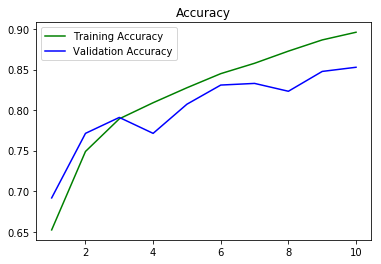

<Figure size 432x288 with 0 Axes>

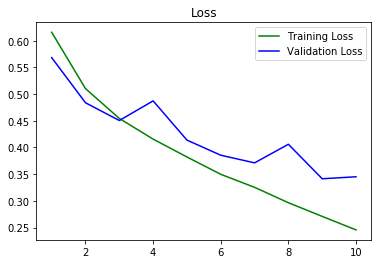

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(1,epochs + 1), history.history['acc'], 'g', label = 'Training Accuracy')
plt.plot(range(1,epochs + 1), history.history['val_acc'], 'b', label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.show()

plt.plot(range(1,epochs + 1), history.history['loss'], 'g', label = 'Training Loss')
plt.plot(range(1,epochs + 1), history.history['val_loss'], 'b', label = 'Validation Loss')
plt.title('Loss')
plt.legend()

plt.figure()
plt.show()

In [0]:
prediction = model.predict(test, verbose=1)

12500/12500 [==============================] - 4s 295us/step


In [0]:
counter = range(1, len(test) + 1)
keras_submission_2 = pd.DataFrame({"id": counter, "label":list(prediction)})
cols = ['label']

for col in cols:
    keras_submission_2[col] = keras_submission_2[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission_2.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_7/catdog_submission_cnn2.csv', index = False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
results_df2=(pd.DataFrame({'TestName': 'Second CNN with Scaling',
   'ProcessingTime': [time2],
   'TrainingSetAccuracy': [score2[1]],
   'TestSetAccuracy': [3.83688]}))
results_df2.set_index('TestName', inplace=True)
results_df2

,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,
Second CNN with Scaling,00:03:02.899984,0.794485,3.83688


# Third Tensorflow Model Training with Keras and Image Scaling

Try to free up some RAM

In [0]:
import gc
gc.collect()

0

### Model Definition and Training

In [0]:
batch_size = 32
epochs = 10

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
__________

Scaling using the ImageDataGenerator library

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)

In [23]:
start=datetime.datetime.now()
history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size, 
                epochs=epochs, verbose=1,
                validation_data=validation_generator,
                validation_steps=len(y_train) // batch_size)
end=datetime.datetime.now()
time3=end-start
print("Time required to fit",end-start)
score3=model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Epoch 1/10
584/584 [==============================] - 43s 74ms/step - loss: 0.7167 - acc: 0.5185 - val_loss: 0.6413 - val_acc: 0.5968
Epoch 2/10
584/584 [==============================] - 42s 72ms/step - loss: 0.6406 - acc: 0.6288 - val_loss: 0.5825 - val_acc: 0.6891
Epoch 3/10
584/584 [==============================] - 42s 73ms/step - loss: 0.5311 - acc: 0.7345 - val_loss: 0.4470 - val_acc: 0.7932
Epoch 4/10
584/584 [==============================] - 42s 73ms/step - loss: 0.4260 - acc: 0.8073 - val_loss: 0.3801 - val_acc: 0.8242
Epoch 5/10
584/584 [==============================] - 42s 73ms/step - loss: 0.3488 - acc: 0.8503 - val_loss: 0.3298 - val_acc: 0.8586
Epoch 6/10
584/584 [==============================] - 43s 73ms/step - loss: 0.3064 - acc: 0.8743 - val_loss: 0.2645 - val_acc: 0.8858
Epoch 7/10
584/584 [==============================] - 42s 73ms/step - loss: 0.2796 - acc: 0.8932 - val_loss: 0.2786 - val_acc: 0.8913
Epoch 8/10
584/584 [==============================] - 42s 73ms

### Model Results and Submission

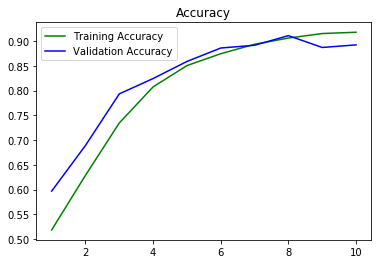

<Figure size 432x288 with 0 Axes>

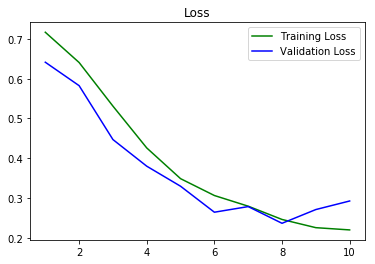

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(range(1,epochs + 1), history.history['acc'], 'g', label = 'Training Accuracy')
plt.plot(range(1,epochs + 1), history.history['val_acc'], 'b', label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.show()

plt.plot(range(1,epochs + 1), history.history['loss'], 'g', label = 'Training Loss')
plt.plot(range(1,epochs + 1), history.history['val_loss'], 'b', label = 'Validation Loss')
plt.title('Loss')
plt.legend()

plt.figure()
plt.show()

In [25]:
prediction = model.predict(test, verbose=1)

12500/12500 [==============================] - 8s 606us/step


In [0]:
counter = range(1, len(test) + 1)
keras_submission_3 = pd.DataFrame({"id": counter, "label":list(prediction)})
cols = ['label']

for col in cols:
    keras_submission_3[col] = keras_submission_3[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

Save results to Google Drive

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

keras_submission_3.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_7/catdog_submission_cnn3.csv', index = False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
results_df3=(pd.DataFrame({'TestName': 'Third CNN with Scaling',
   'ProcessingTime': [time3],
   'TrainingSetAccuracy': [score3[1]],
   'TestSetAccuracy': [3.83688]}))
results_df3.set_index('TestName', inplace=True)
results_df3

,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,
Third CNN with Scaling,00:06:55.942243,0.818532,3.83688


# Results

100.00% confidence this is a Dog


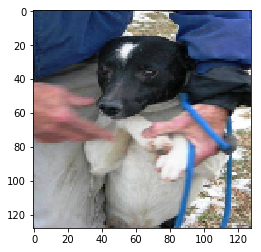

100.00% confidence this is a Dog


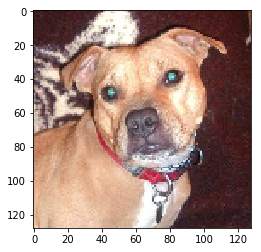

100.00% confidence this is a Dog


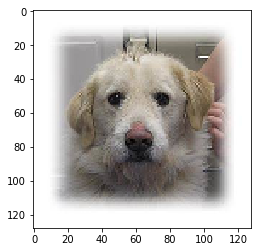

100.00% confidence this is a Dog


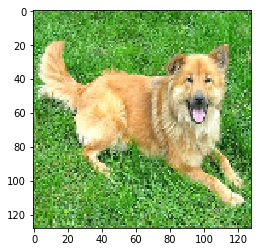

100.00% confidence this is a Cat


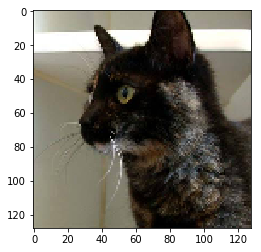

100.00% confidence this is a Dog


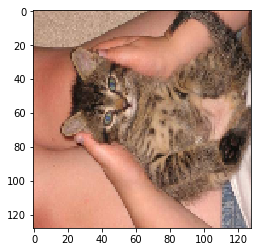

100.00% confidence this is a Cat


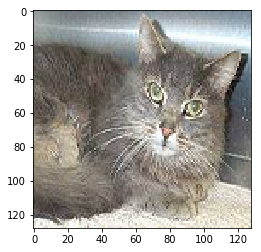

100.00% confidence this is a Cat


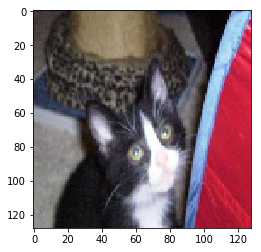

100.00% confidence this is a Cat


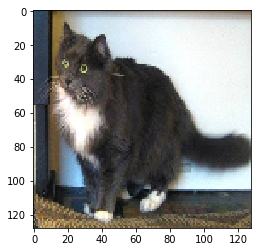

100.00% confidence this is a Cat


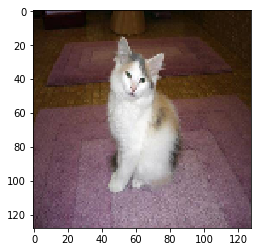

In [0]:
for i in range(0,10):
    if prediction[i, 0] >= 0.5: 
        print('{:.2%} confidence this is a Dog'.format(prediction[i][0]))
    else: 
        print('{:.2%} confidence this is a Cat'.format(1-prediction[i][0]))
        
    plt.imshow(test[i])
    plt.show()

To try with some non-supplied pictures, I included some pictures of cats of dogs from friends and family

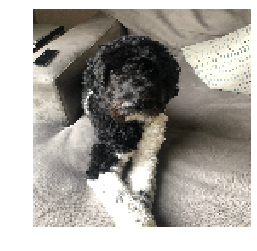

In [32]:
PETS_DIR='/content/gdrive/My Drive/MSDS-422-Gift/module_7/pets/'
pet_images = [PETS_DIR+i for i in os.listdir(PETS_DIR)]
pets_test, pets_test_labels = prepare_data(pet_images)
plt.imshow(pets_test[0])
plt.axis("off")
plt.show()

6/6 [==============================] - 0s 51ms/step
100.00% confidence this is a Dog


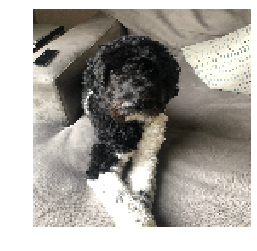

100.00% confidence this is a Dog


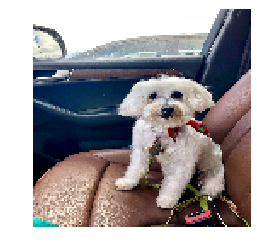

100.00% confidence this is a Cat


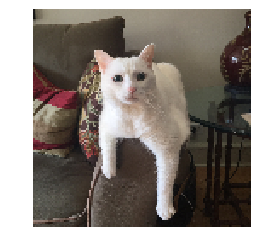

100.00% confidence this is a Dog


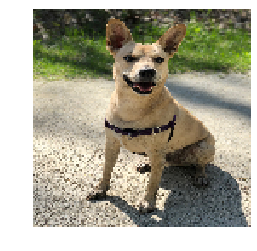

100.00% confidence this is a Dog


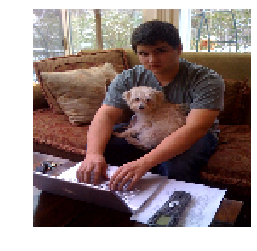

100.00% confidence this is a Cat


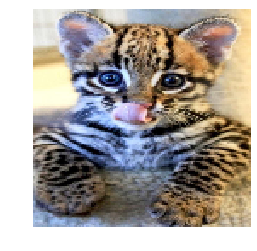

In [33]:
pet_prediction = model.predict(pets_test, verbose=1)

for i in range(0,6):
    if pet_prediction[i, 0] >= 0.5: 
        print('{:.2%} confidence this is a Dog'.format(pet_prediction[i][0]))
    else: 
        print('{:.2%} confidence this is a Cat'.format(1-pet_prediction[i][0]))
        
    plt.imshow(pets_test[i])
    plt.axis("off")
    plt.show()

In [0]:
results_df_compiled = pd.concat([results_df,results_df2,results_df3], ignore_index=False)
results_df_compiled

,ProcessingTime,TrainingSetAccuracy,TestSetAccuracy
TestName,,,
Initial CNN without scaling,00:02:18.949828,0.500481,17.15819
Second CNN with Scaling,00:03:02.899984,0.794485,3.83688
Third CNN with Scaling,00:06:55.942243,0.818532,3.83688


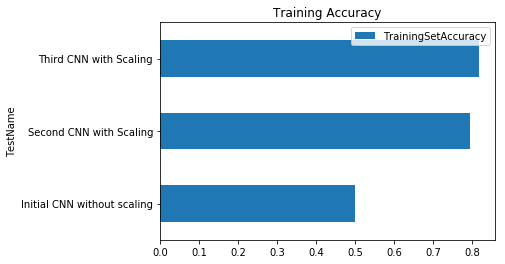

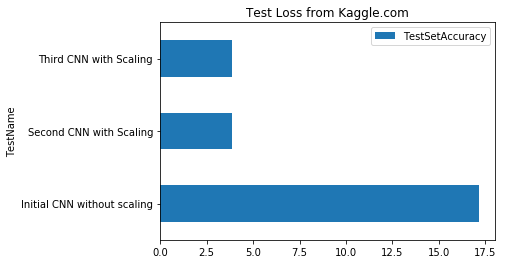

In [0]:
results_df_compiled[['TrainingSetAccuracy']].plot(kind='barh', title='Training Accuracy')
results_df_compiled[['TestSetAccuracy']].plot(kind='barh', title='Test Loss from Kaggle.com')
plt.show()

# Recommendations

Of the methods tested, the CNN convolutional model performed the best. Scaling was especially important for this exercise, and the ImageDataGenerator class helped quite a bit.